# Exercise Sheet #2: Battleships (1/2)

### Probabilistic Machine Learning

- **Lecturer**: Prof. Philipp Hennig
- **Term**: SoSe 2020
- **Due Date**: Monday, 04 May 2020, 10am


![battleship rules](https://upload.wikimedia.org/wikipedia/commons/e/e4/Battleships_Paper_Game.svg)

Over the course of two weeks, we will implement an agent that can play the pen-and-paper game _Battleships_. The goal of this exercise sheet is to find exact prior probabilities of getting a hit by enumeration, and to update to a posterior given observations of hits and misses. This week we will understand why we can't construct the agent with this approach.  

Next week we will use Monte Carlo techniques to build an agent that we can play against :). Stay tuned!

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

### **2.1** A priori probability for a hit with one boat

**Tasks**
1. Write a function that takes the length of a boat and that returns the prior probability to observe a hit.
2. Plot the prior for a carrier (length 5).


*Hint:* You can find this probability by enumerating all possible positions of the boat.

In [2]:
field_size = 10

_Note:_ Let `i` denote the _row_ index and `j` the _column_ index

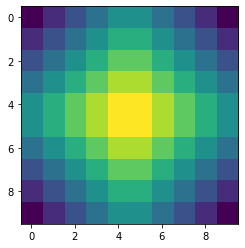

In [3]:
def boat_prior(boat_length, field_size):
    """
    Computes the prior probability to get a hit given the boat length and the size of the board.
    For a single-boat setup only.
    :param boat_length: Length of the boat, type: int
    :param field_size: size of the board, type: int
    
    :returns: np.ndarray of size (field_size, field_size) containing the probability of a hit for every field.
    """
    
    #######################################
    
    prior = np.zeros([field_size, field_size])
    
    # Create horizontal boats
    for x in range(field_size):
        for y in range(field_size - boat_length + 1):
            for k in range(boat_length):
                prior[x, y+k] += 1
    
    # Create vertical boats
    for y in range(field_size):
        for x in range(field_size - boat_length + 1):
            for k in range(boat_length):
                prior[x+k, y] += 1

    prior /= prior.sum()
    
    #######################################

    return prior

L_carrier = 5
carrier_prior = boat_prior(L_carrier, field_size)
plt.imshow(carrier_prior)

In [4]:
# Sanity check: carrier_prior should sum to the length of the boat
carrier_prior.sum()

1.0000000000000002

### **2.2** Updating to a posterior given hit/miss observations

Let us define an `observation_board` that contains the observations. We use the following notation:  
    `0` unseen field  
    `-1` miss (water)  
    `1` hit  

**Task 1:** Write a function that takes as input the `observation_board` as well as the length of one boat, and that returns an array that contains the probability to get a hit at every coordinate of the field.

*Hint:* Again, this can be achieved by enumeration. Take care of all the constraints imposed by the `observation_board`!

In [4]:
def posterior_one_ship(observation_board, boat_length):
    """
    Computes the posterior probability to get a hit given an array of observed hits and misses as well as the boat length.
    For a single-boat setup only.
    :param observation_board: the board containing unobserved locations (0), misses (-1), and hits (1), type: np.ndarray
    :param boat_length: Length of the boat, type: int
    
    :returns: np.ndarray of the same size as the observation board containing the probability of a hit 
              for every field given the observations
    """
    
    #######################################
    
    rows = observation_board.shape[0]
    cols = observation_board.shape[1]
    
    exception_msg = "Boat has invalid position"
    
    prior = np.zeros([rows, cols])
    
    # Create horizontal boats
    for x in range(field_size):
        for y in range(field_size - boat_length + 1):
            for k in range(boat_length):
                prior[x, y+k] += 1
    
    # Create vertical boats
    for y in range(field_size):
        for x in range(field_size - boat_length + 1):
            for k in range(boat_length):
                prior[x+k, y] += 1
    
    # Incorporate misses
    misses = np.argwhere(observation_board == -1)
    
    for x, y in misses:
        x_min = max(x-boat_length+1, 0)
        x_max = min(x+boat_length, rows)
        
        y_min = max(y-boat_length+1, 0)
        y_max = min(y+boat_length, cols)
        
        for x_ in range(x_min, x+1):
            if x_ + boat_length - 1 < rows:
                for i in range(boat_length):
                    prior[x_+i, y] -= 1
        
        for y_ in range(y_min, y+1):
            if y_ + boat_length - 1 < cols:
                for j in range(boat_length):
                    prior[x, y_+j] -= 1
            
    # Incorporate hits
    hits = np.argwhere(observation_board == 1)
    
    if len(hits) > 0:
        position = "unk"
        max_distance = 0
        
        for x, y in hits:
            for x_, y_ in hits:
                
                x_distance = abs(x - x_)
                y_distance = abs(y - y_)
                
                if x == x_ and y == y_:
                    pass
                
                elif (x_distance <= boat_length-1) and y == y_:
                    max_distance = max(max_distance, x_distance)
                    
                    if position == "unk" or position == "ver":
                        position = "ver"
                    else:
                        raise Exception(exception_msg)
                        
                elif (y_distance <= boat_length-1) and x == x_:
                    max_distance = max(max_distance, y_distance)
                    
                    if position == "unk" or position == "hor":
                        position = "hor"
                    else:
                        raise Exception(exception_msg)
                        
                else:
                    raise Exception(exception_msg)

        prior = np.zeros((rows, cols))
        
        spare = boat_length - max_distance - 1
            
        if position == "hor" or position == "unk":
            x = hits[0, 0]
            
            y_min = np.min(hits[:, 1])
            y_max = np.max(hits[:, 1])
            
            for y in range(max(0, y_min - spare), min(y_min + 1, cols)):
                if y + boat_length - 1 < cols:
                    for j in range(boat_length):
                        prior[x, y+j] += 1
            
        if position == "ver" or position == "unk":
            y = hits[0, 1]
            
            x_min = np.min(hits[:, 0])
            x_max = np.max(hits[:, 0])
            
            for x in range(max(0, x_min - spare), min(x_min + 1, rows)):
                if x + boat_length - 1 < rows:
                    for i in range(boat_length):
                        prior[x+i, y] += 1
            
    posterior = prior / prior.sum()
    
    #######################################

    return posterior

**Task 2:** Test your function on the following `observation_board`s (just run the cells)

In [5]:
# board 1: Only misses
obs_board_1 = np.zeros((field_size, field_size)); obs_board_1[[1, 2, 5, 8], [8, 3, 4, 6]] = -1

# board 2: a few misses, one hit
obs_board_2 = np.copy(obs_board_1); obs_board_2[7, 1] = 1

# board 3: a few misses, two hits
obs_board_3 = np.copy(obs_board_2); obs_board_3[6, 1] = 1

# board 4: two for one boat impossible hits: This should cause an error
obs_board_4 = np.copy(obs_board_2); obs_board_4[6, 2] = 1

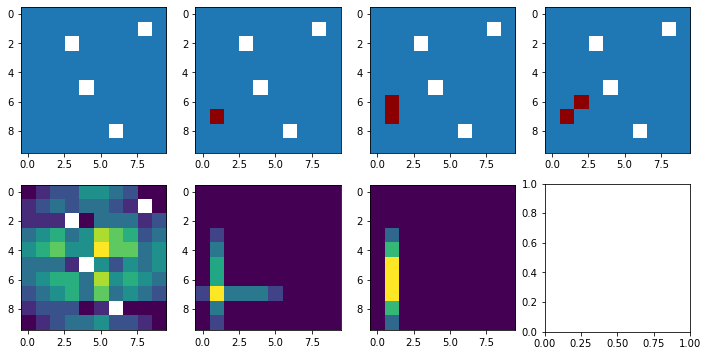

In [6]:
### VISUALIZATION
from matplotlib import colors

# making a custom discrete colormap for hits and misses
cmap_discrete = colors.ListedColormap(['white', 'C0','darkred'])
boundaries = [-1.5, -0.5, 0.5, 1.5]
norm = colors.BoundaryNorm(boundaries, cmap_discrete.N, clip=True)

# Plot the boards and the corresponding posterior
f, axs = plt.subplots(2, 4, figsize=(12,6))

cmap = matplotlib.cm.viridis  # Can be any colormap that you want after the cm
cmap.set_bad(color='w')

# board 1
post_1 = posterior_one_ship(obs_board_1, 5)
axs[0, 0].imshow(obs_board_1, cmap=cmap_discrete, norm=norm)
axs[1, 0].imshow(np.ma.masked_where(post_1 == 0, post_1), cmap=cmap)

# board 2
axs[0, 1].imshow(obs_board_2, cmap=cmap_discrete, norm=norm)
axs[1, 1].imshow(posterior_one_ship(obs_board_2, 5))

# board 3
axs[0, 2].imshow(obs_board_3, cmap=cmap_discrete, norm=norm)
axs[1, 2].imshow(posterior_one_ship(obs_board_3, 5))

# board 4
axs[0, 3].imshow(obs_board_4, cmap=cmap_discrete, norm=norm)
try:
    axs[1, 3].imshow(posterior_one_ship(obs_board_4, 5))
except:
    pass

In [7]:
# board 4 should raise an error
posterior_one_ship(obs_board_4, 5)

Exception: Boat has invalid position

### **2.3** Towards battleship with more than one boat
_Note: No coding required!_

Next week's assignment will deal with the full game of Battleships, which, according to the above rules, contains seven ships.

1. Think about how you would need to modify your above routines to compute  
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   (a) the prior over ship locations   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   (b) the posterior over ship locations given hit/miss observations  
    by enumerating all states. Describe the changes you would need to make to your code.
2. Why will it be hard to compute the posterior with multiple boats?

#### **Answers**

1. (a) We would have to consider every possible arrangement of boats such that there are no inconsistencies such as collisions between two or more boats.
1. (b) We would have to consider every possible length of boat as well as whether there would be collision between two or more hits (e.g. in situations like 1st-row-4th-column plot above if there were 2+ boats instead of only 1).
2. The posterior would be hard to compute due to combinatorial explosion. The total number of arrangements of boats is extremely large, even for toy problems like these 10x10 grids.